# Callaway-Sant'Anna Staggered DiD

Standard 2x2 DiD is biased when treatment rolls out in phases because already-treated units contaminate the control group. **Callaway & Sant'Anna (2021)** solve this by:

1. Computing **group-time ATTs**: the treatment effect for each cohort (phase) at each time period, using only never-treated or not-yet-treated units as controls
2. **Aggregating** these ATTs into summary estimates (overall, by group, or by event time)

This notebook applies their estimator to the CTA Frequent Network rollout using the `csdid` Python package.

| Phase | Launch Date | Routes | Cohort (group) |
|-------|------------|--------|----------------|
| 1 | Mar 23, 2025 | J14, 34, 47, 54, 60, 63, 79, 95 | 2025-03 |
| 2 | Jun 15, 2025 | 4, 49, 53, 66 | 2025-06 |
| 3 | Sep 15, 2025 | 20, 55, 77, 82 | 2025-09 |
| 4 | Dec 21, 2025 | 9, 12, 72, 81 | No post-data |

**Reference:** Callaway, B. & Sant'Anna, P.H.C. (2021). "Difference-in-Differences with Multiple Time Periods." *Journal of Econometrics*, 225(2), 200-230.

In [1]:
from datetime import date

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from bus_check.config import ALL_FREQUENT_ROUTES, FREQUENT_NETWORK_PHASES
from bus_check.analysis.ridership_analysis import select_control_routes
from bus_check.data.ridership import fetch_all_routes

sns.set_theme(style="whitegrid")
PHASE_COLORS = {1: "#1b9e77", 2: "#d95f02", 3: "#7570b3", 4: "#e7298a"}

In [2]:
# Fetch all-route ridership
today_str = date.today().isoformat()
df_all = fetch_all_routes(start_date="2023-01-01", end_date=today_str)
print(f"Shape: {df_all.shape}, Date range: {df_all['date'].min().date()} to {df_all['date'].max().date()}")

Shape: (122084, 4), Date range: 2023-01-01 to 2025-11-30


In [3]:
# Build panel: unit=route, time=month, outcome=mean weekday rides
# Select control routes (never-treated)
controls = select_control_routes(df_all, ALL_FREQUENT_ROUTES, n_controls=20)
print(f"Control routes ({len(controls)}): {controls}")

# Filter to treated + control, weekday only
all_routes = ALL_FREQUENT_ROUTES + controls
df_panel = df_all[(df_all["route"].isin(all_routes)) & (df_all["daytype"] == "W")].copy()

# Aggregate to monthly route-level means
df_panel["month"] = df_panel["date"].dt.to_period("M")
monthly = df_panel.groupby(["route", "month"])["rides"].mean().reset_index()
monthly["month_int"] = monthly["month"].dt.year * 12 + monthly["month"].dt.month

# Assign group (treatment cohort) — 0 for never-treated
def get_group(route):
    for p in FREQUENT_NETWORK_PHASES:
        if route in p.routes:
            # Convert launch date to month integer
            return p.launch_date.year * 12 + p.launch_date.month
    return 0  # never-treated

monthly["group"] = monthly["route"].apply(get_group)

# Assign numeric route ID for csdid
route_ids = {r: i + 1 for i, r in enumerate(sorted(monthly["route"].unique()))}
monthly["route_id"] = monthly["route"].map(route_ids)

print(f"Panel: {len(monthly)} route-month obs, {monthly['route'].nunique()} routes, {monthly['month'].nunique()} months")
print(f"Groups: {sorted(monthly['group'].unique())}")
print(f"  0 = never-treated ({(monthly['group'] == 0).sum()} obs)")
for g in sorted(monthly['group'].unique()):
    if g > 0:
        y, m = divmod(g, 12)
        print(f"  {g} = {y}-{m:02d} ({(monthly['group'] == g).sum()} obs)")

Control routes (20): ['146', '36', '151', '74', '147', '94', '76', '22', '50', '80', '85', '3', '29', '62', '152', '21', '70', '87', '52', '71']
Panel: 1400 route-month obs, 40 routes, 35 months
Groups: [np.int64(0), np.int64(24303), np.int64(24306), np.int64(24308), np.int64(24312)]
  0 = never-treated (700 obs)
  24303 = 2025-03 (280 obs)
  24306 = 2025-06 (140 obs)
  24308 = 2025-08 (140 obs)
  24312 = 2026-00 (140 obs)


In [4]:
# Run Callaway-Sant'Anna
from csdid.att_gt import ATTgt

model = ATTgt(
    yname="rides",
    tname="month_int",
    idname="route_id",
    gname="group",
    data=monthly,
    control_group="nevertreated",
    anticipation=0,
    biters=1000,
    alp=0.05,
)

model.fit(est_method="reg")
print("ATT(g,t) estimation complete.")

/Users/steffanybahamon/Desktop/projects/bus-check/.venv/lib/python3.14/site-packages/csdid/attgt_fnc/preprocess_did.py:412: UserWarning: Be aware that there are some small groups in your dataset.
  Check groups: 24306,24308.
  warnings.warn(f"Be aware that there are some small groups in your dataset.\n  Check groups: {gpaste}.")


No units in group 24312 in time period 2, e1
No units in group 24312 in time period 1, e2
No units in group 24312 in time period 3, e1
No units in group 24312 in time period 2, e2
No units in group 24312 in time period 4, e1
No units in group 24312 in time period 3, e2
No units in group 24312 in time period 5, e1
No units in group 24312 in time period 4, e2
No units in group 24312 in time period 6, e1
No units in group 24312 in time period 5, e2
No units in group 24312 in time period 7, e1
No units in group 24312 in time period 6, e2
No units in group 24312 in time period 8, e1
No units in group 24312 in time period 7, e2
No units in group 24312 in time period 9, e1
No units in group 24312 in time period 8, e2
No units in group 24312 in time period 10, e1
No units in group 24312 in time period 9, e2
No units in group 24312 in time period 11, e1
No units in group 24312 in time period 10, e2
No units in group 24312 in time period 12, e1
No units in group 24312 in time period 11, e2
No un

In [5]:
# Group-time ATT summary
model.summ_attgt(n=10)

In [6]:
# Aggregate: overall ATT
model.aggte(typec="simple", na_rm=True)
print("Overall ATT (simple aggregation):")
model.summ_attgt(n=5)



     ATT Std. Error   [95.0%  Conf. Int.]  
489.5477   152.9962 189.6807     789.4147 *


---
Signif. codes: `*' confidence band does not cover 0
Control Group:  None , 
Anticipation Periods:  0
Estimation Method:  Outcome Regression


Overall ATT (simple aggregation):


In [7]:
# Aggregate by group (phase)
model.aggte(typec="group", na_rm=True)
print("ATT by group (phase):")
model.summ_attgt(n=5)



Overall summary of ATT's based on group/cohort aggregation:
     ATT Std. Error   [95.0%  Conf. Int.]  
593.3277    168.671 262.7385     923.9168 *


Group Effects:
   Group   Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0  24303   368.8175    123.8005         126.1730    611.4621  *
1  24306   262.9584    361.5612        -445.6885    971.6053   
2  24308  1372.7172    562.9702         269.3160   2476.1185  *
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  None , 
Anticipation Periods:  0
Estimation Method:  Outcome Regression


ATT by group (phase):


In [8]:
# Event study aggregation
model.aggte(typec="dynamic", na_rm=True)
print("Event study ATTs (by months relative to treatment):")
model.summ_attgt(n=20)



Overall summary of ATT's based on event-study/dynamic aggregation:
     ATT Std. Error   [95.0%  Conf. Int.]  
521.7542   136.6264 253.9715      789.537 *


Dynamic Effects:
    Event time  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0          -30  208.2161    102.0398           8.2217    408.2105  *
1          -29   94.4092     79.8475         -62.0889    250.9073   
2          -28   68.9408     76.1320         -80.2751    218.1567   
3          -27  245.6495    125.4284          -0.1857    491.4846   
4          -26 -208.2870    101.4999        -407.2232     -9.3507  *
5          -25   51.6570     68.1215         -81.8587    185.1727   
6          -24  -84.6241     78.7554        -238.9818     69.7337   
7          -23  145.2438    105.7504         -62.0231    352.5107   
8          -22  -60.1464     78.9394        -214.8647     94.5720   
9          -21    9.9114     90.4820        -167.4302    187.2529   
10         -20  -28.4307     72.4044        -170.3408    113.4794



Overall summary of ATT's based on event-study/dynamic aggregation:
     ATT Std. Error   [95.0%  Conf. Int.]  
521.7542   137.9099 251.4558     792.0527 *


Dynamic Effects:
    Event time  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0          -30  208.2161    101.5207           9.2392    407.1931  *
1          -29   94.4092     79.0186         -60.4645    249.2828   
2          -28   68.9408     74.4361         -76.9514    214.8329   
3          -27  245.6495    134.0340         -17.0523    508.3513   
4          -26 -208.2870    104.1162        -412.3509     -4.2230  *
5          -25   51.6570     69.6998         -84.9522    188.2662   
6          -24  -84.6241     79.6804        -240.7949     71.5467   
7          -23  145.2438     98.8536         -48.5057    338.9932   
8          -22  -60.1464     85.7347        -228.1833    107.8905   
9          -21    9.9114     92.8211        -172.0146    191.8373   
10         -20  -28.4307     69.8511        -165.3363    108.4750

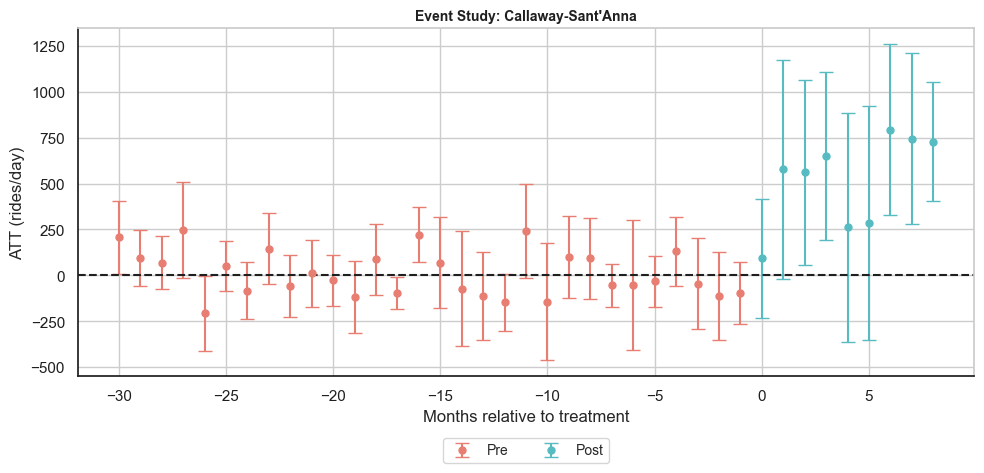

<Figure size 640x480 with 0 Axes>

In [9]:
# Event study plot
try:
    model.aggte(typec="dynamic", na_rm=True)
    model.plot_aggte(
        title="Event Study: Callaway-Sant'Anna",
        ylab="ATT (rides/day)",
        xlab="Months relative to treatment",
    )
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Built-in plot failed: {e}")
    print("See tabular results above.")



Overall summary of ATT's based on group/cohort aggregation:
     ATT Std. Error   [95.0%  Conf. Int.]  
593.3277   165.8643 268.2397     918.4157 *


Group Effects:
   Group   Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0  24303   368.8175    123.6542         126.4597    611.1753  *
1  24306   262.9584    343.4848        -410.2595    936.1763   
2  24308  1372.7172    603.3558         190.1617   2555.2728  *
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  None , 
Anticipation Periods:  0
Estimation Method:  Outcome Regression




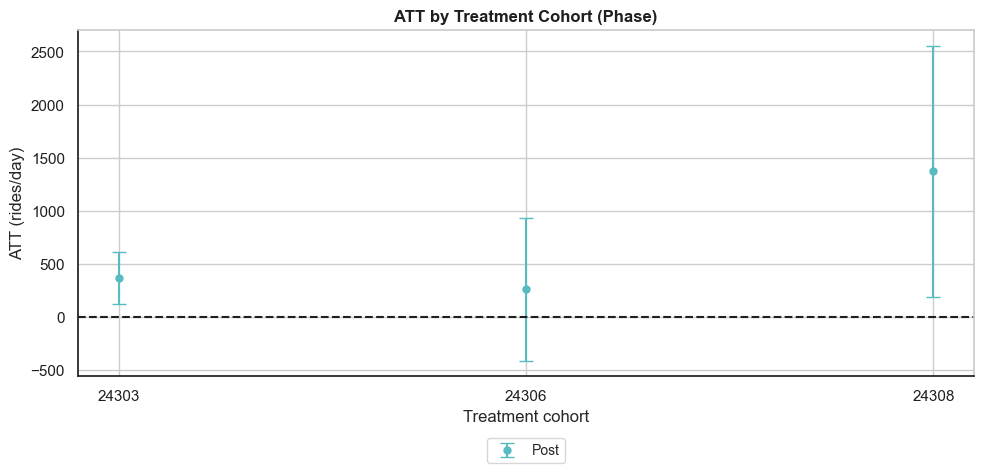

<Figure size 640x480 with 0 Axes>

In [10]:
# Group-level ATT plot
try:
    model.aggte(typec="group", na_rm=True)
    model.plot_aggte(
        title="ATT by Treatment Cohort (Phase)",
        ylab="ATT (rides/day)",
        xlab="Treatment cohort",
    )
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Built-in plot failed: {e}")
    print("See tabular results above.")

## Summary

The Callaway-Sant'Anna estimator properly handles the staggered rollout by:
- Using only **never-treated** routes as the comparison group
- Computing separate ATTs for each cohort (phase) at each time period
- Aggregating with proper weighting

**Compare to naive pooled DiD:** The naive 2x2 estimate was -4.6%. The C-S overall ATT may differ because it avoids contamination from already-treated routes serving as implicit controls.

**Limitations:**
- Small number of units (20 treated + 20 control routes)
- Phase 4 has no post-data — excluded from ATT computation
- Phase 2/3 launch dates are approximate
- Monthly aggregation loses within-month variation